# Challenge: If a tree falls in the forest...

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
import seaborn as sns
import time
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [15]:
kickstarter_data = pd.read_csv('kickstarter_2018.csv')

In [16]:
kickstarter_data.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [17]:
kickstarter_data.describe()

,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,1.074731e+09,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


In [18]:
kickstarter_data['state'] = kickstarter_data['state'].apply(lambda x: 1 if x == 'successful' else 0 )

In [19]:
kickstarter_data['state'].value_counts()

0    244705
1    133956
Name: state, dtype: int64

In [20]:
244705 /(133956+244705)

0.6462376637678556

In [21]:
success_data = kickstarter_data[kickstarter_data['state'] == 1]
fail_data = kickstarter_data[kickstarter_data['state'] == 0]

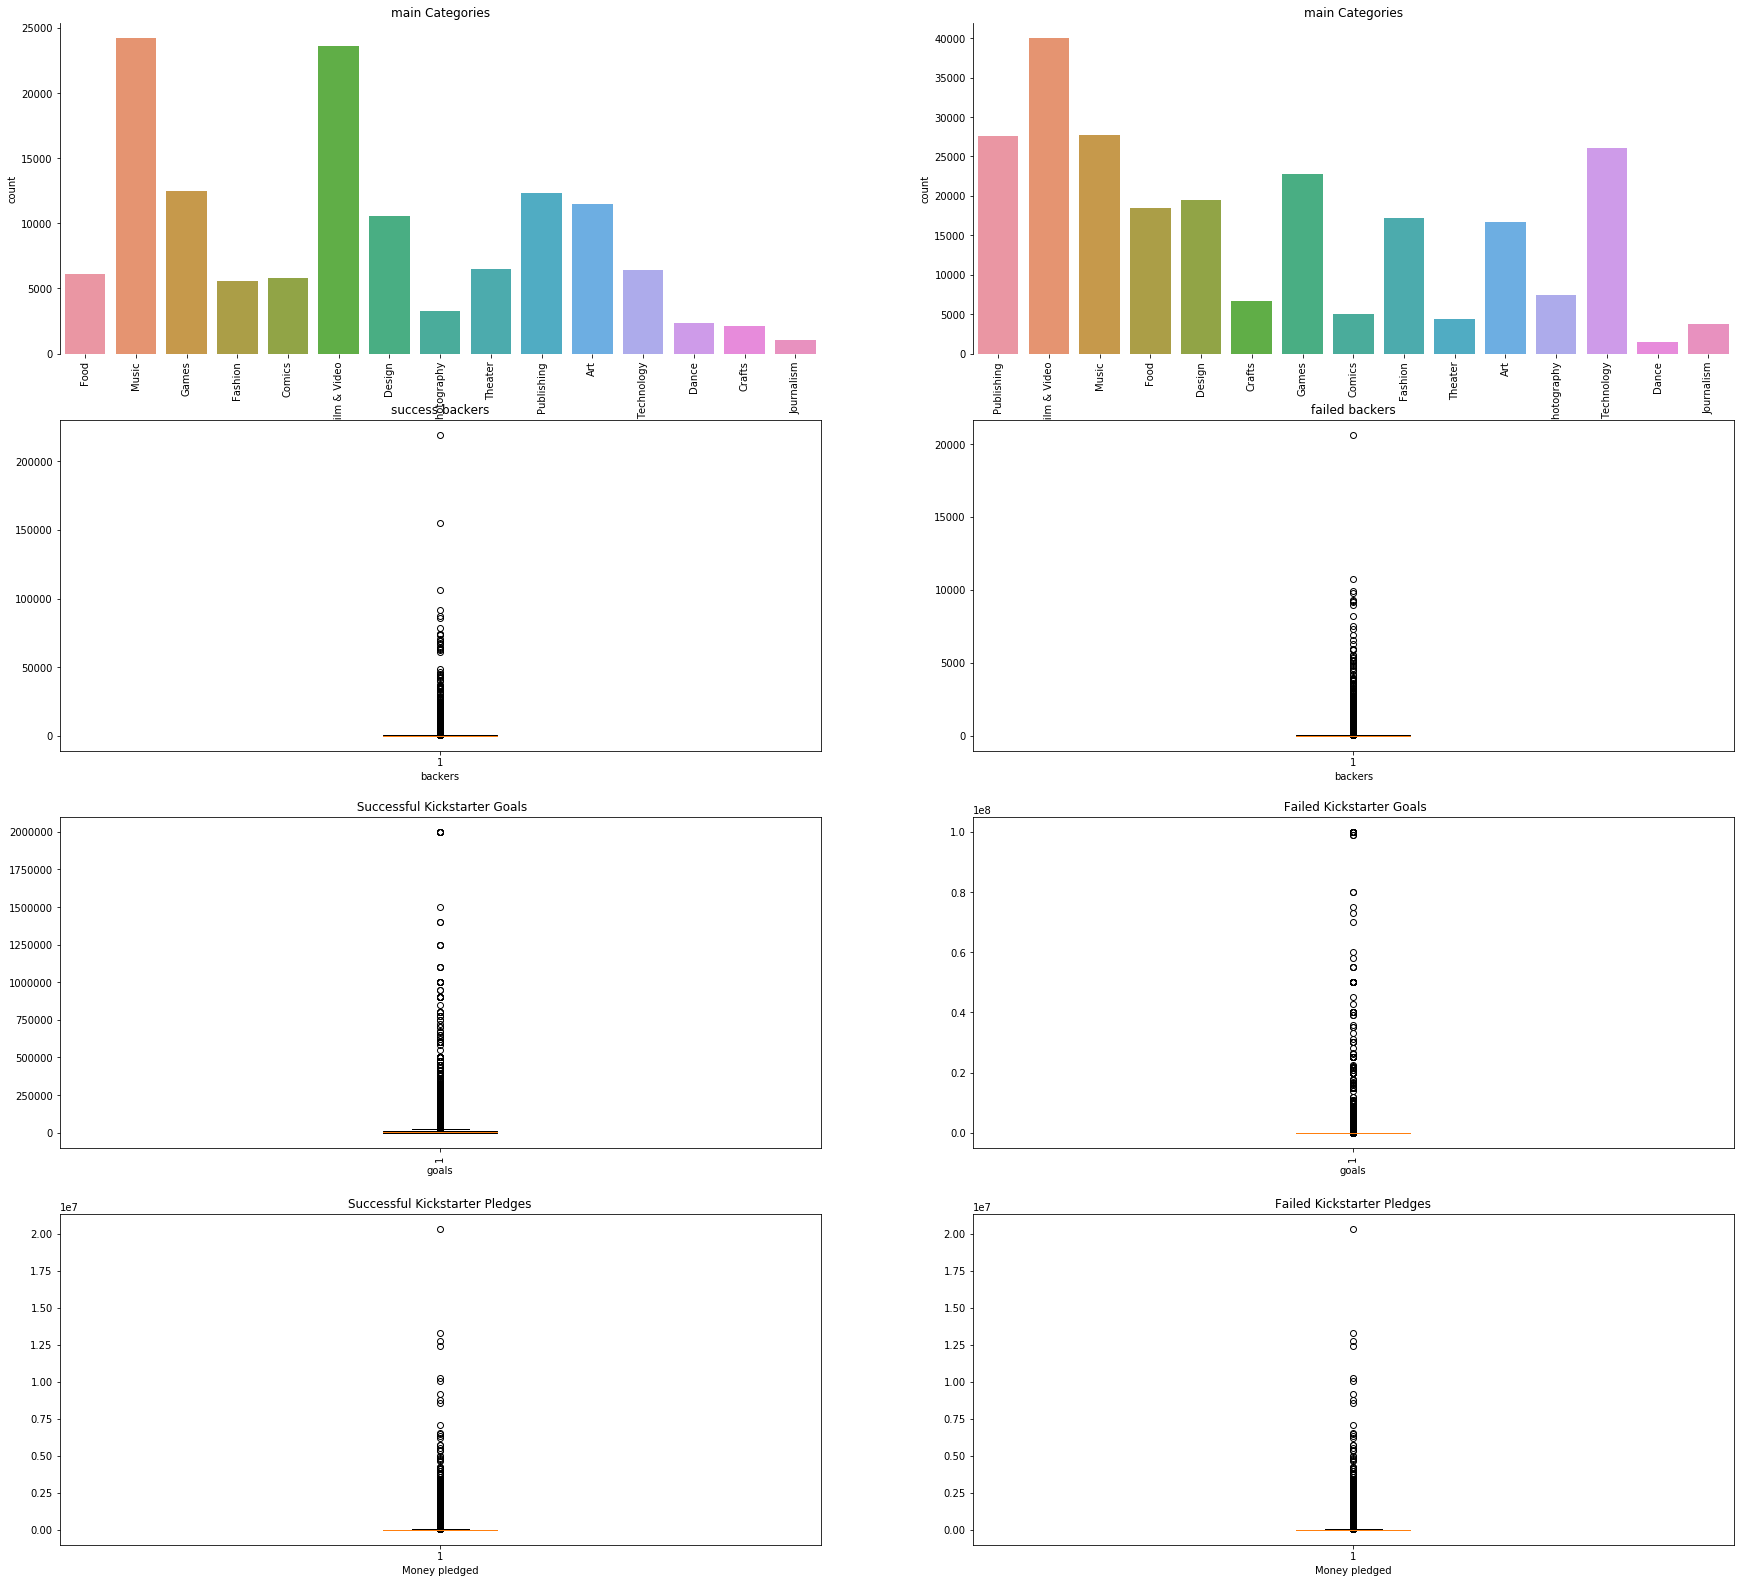

In [22]:
plt.figure(figsize=(30, 28))
plt.subplot(4, 2, 1)
sns.countplot(success_data['main_category'])
plt.title('main Categories')
plt.xlabel("Kickstarter successes in each category")
plt.xticks(rotation = 90)
sns.despine(left=False, bottom=True)

plt.subplot(4, 2, 2)
sns.countplot(fail_data['main_category'])
plt.title('main Categories')
plt.xlabel("Kickstarter nonsuccesses in each category")
plt.xticks(rotation = 90)
sns.despine(left=False, bottom=True)

plt.subplot(4, 2, 3)
plt.boxplot(success_data['backers'])
plt.title('success backers')
plt.xlabel("backers")

plt.subplot(4, 2, 4)
plt.boxplot(fail_data['backers'])
plt.title('failed backers')
plt.xlabel("backers")

plt.subplot(4, 2, 5)
plt.boxplot(success_data['goal'])
plt.title(" Successful Kickstarter Goals")
plt.xlabel("goals")
plt.xticks(rotation = 90)

plt.subplot(4, 2, 6)
plt.boxplot(fail_data['goal'])
plt.title(" Failed Kickstarter Goals")
plt.xlabel("goals")
plt.xticks(rotation = 90)

plt.subplot(4, 2, 7)
plt.boxplot(success_data['pledged'])
plt.title('Successful Kickstarter Pledges')
plt.xlabel("Money pledged")

plt.subplot(4, 2, 8)
plt.boxplot(success_data['pledged'])
plt.title('Failed Kickstarter Pledges')
plt.xlabel("Money pledged")

plt.show()

### Cutting our the outliers

In [101]:
new_ks_data = kickstarter_data[kickstarter_data['pledged']< kickstarter_data['pledged'].quantile(0.70)]

## Selecting features for the model

In [24]:
X = new_ks_data[['main_category', 'country','backers', 'goal', 'usd_goal_real']]
y = new_ks_data["state"]

Converting the categorical values into numerical values so decision tree can run

In [25]:
X = pd.get_dummies(X)

## Decision Tree

[19] [0.93692426866829615]


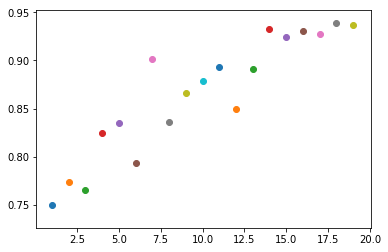

In [100]:
# Writing a function to show the best max_depth with max_feature of auto showing a scatter plot with results.
def best_depth(crit, max_feat, max_dep):
    for i in range(1, max_dep):
        score = [0]
        best_dep = [0]
        decision_tree = tree.DecisionTreeClassifier(criterion=crit, max_features = max_feat, max_depth = i)
        decision_tree.fit(X, y)
        results = cross_val_score(decision_tree, X, y, cv=5)
        plt.scatter(i, np.mean(results))
        if np.mean(results)> score:
            del best_dep[0]
            best_dep.append(i)
            del score[0]
            score.append(np.mean(results))
            
    print(best_dep, score)
best_depth('gini', 'auto', 20)     

[19] [0.94181469535179363]


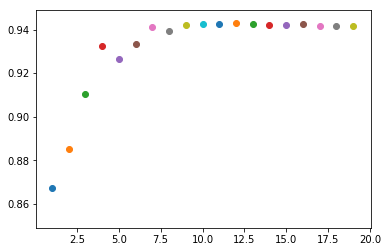

In [98]:
# Writing a function to show the best max_feature with showing a scatter plot with results.
def best_feature(crit, max_feat, max_dep):
    for i in range(1, max_feat):
        score = [0]
        best_feat = [0]
        decision_tree = tree.DecisionTreeClassifier(criterion=crit, max_features = i, max_depth = max_dep)
        decision_tree.fit(X, y)
        results = cross_val_score(decision_tree, X, y, cv=5)
        plt.scatter(i, np.mean(results))
        if np.mean(results)> score:
            del best_feat[0]
            best_feat.append(i)
            del score[0]
            score.append(np.mean(results))
            
    print(best_feat, score)
best_feature('gini', 20, 19) 

In [52]:
decision_tree = tree.DecisionTreeClassifier(criterion='entropy', max_features = 19, max_depth = 19)
decision_tree.fit(X, y)
cross_val_score(decision_tree, X, y, cv=5)

array([ 0.94262944,  0.94126237,  0.94439957,  0.94387137,  0.94174214])

In [ ]:
# This was my attempt on getting a plot with all the parameters after an hour of waiting I interupted it.
crit_list =['gini', 'entropy']
def best_parameters(crit, max_feat, max_dep):
    score = [0]
    best_feat = [0]
    best_dep = [0]
    best_crit = ['gini']
    for i in range(1, max_feat):
        for j in range(1, max_dep):
            for criterion in crit:
                decision_tree = tree.DecisionTreeClassifier(criterion=criterion, max_features = i, max_depth = j)
                decision_tree.fit(X, y)
                results = cross_val_score(decision_tree, X, y, cv=5)
              
                if np.mean(results)> score:
                    del best_feat[0]
                    best_feat.append(i)
                    del best_dep[0]
                    best_dep.append(j)
                    del best_crit[0]
                    best_crit.append(criterion)
                    del score[0]
                    score.append(np.mean(results))

    print(best_crit, best_feat, best_dep, score)
best_parameters(crit_list, 20, 20) 

## Forest

[19] [0.94818720568336334]


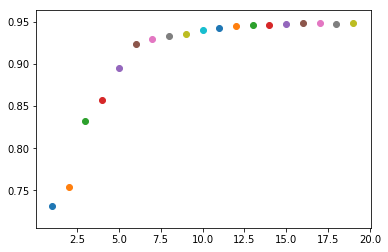

In [102]:
def best_depth(crit, max_feat, max_dep):
    for i in range(1, max_dep):
        score = [0]
        best_dep = [0]
        forest = ensemble.RandomForestClassifier(criterion=crit, max_features = max_feat, max_depth = i)
        forest.fit(X, y)
        results = cross_val_score(forest, X, y, cv=5)
        plt.scatter(i, np.mean(results))
        if np.mean(results)> score:
            del best_dep[0]
            best_dep.append(i)
            del score[0]
            score.append(np.mean(results))
            
    print(best_dep, score)
best_depth('gini', 'auto', 20)   

[19] [0.93608213438293952]


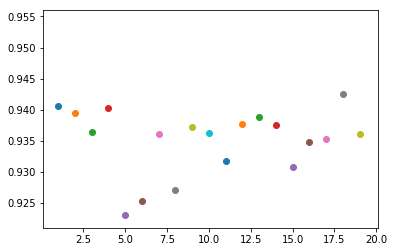

In [103]:
def best_feature(crit, max_feat, max_dep):
    for i in range(1, max_feat):
        score = [0]
        best_feat = [0]
        forest = ensemble.RandomForestClassifier(criterion=crit, max_features = i, max_depth = max_dep)
        forest.fit(X, y)
        results = cross_val_score(decision_tree, X, y, cv=5)
        plt.scatter(i, np.mean(results))
        if np.mean(results)> score:
            del best_feat[0]
            best_feat.append(i)
            del score[0]
            score.append(np.mean(results))
            
    print(best_feat, score)
best_feature('gini', 20, 19)

[24] [0.93758911786919374]


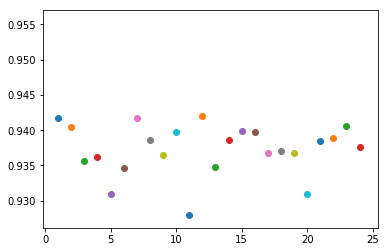

In [104]:
def best_est(crit, max_feat, max_dep, n_est):
    for i in range(1, n_est):
        score = [0]
        best_feat = [0]
        forest = ensemble.RandomForestClassifier(criterion=crit, max_features = max_feat, max_depth = max_dep, n_estimators = i)
        forest.fit(X, y)
        results = cross_val_score(decision_tree, X, y, cv=5)
        plt.scatter(i, np.mean(results))
        if np.mean(results)> score:
            del best_feat[0]
            best_feat.append(i)
            del score[0]
            score.append(np.mean(results))
            
    print(best_feat, score)
best_est('gini', 18, 19, 25)

In [105]:
rfc = ensemble.RandomForestClassifier(criterion = 'gini', n_estimators = 12,  max_depth= 19, max_features = 18)
rfc.fit(X, y)
rfc.feature_importances_

array([  5.72513624e-01,   2.33829607e-01,   1.47040515e-01,
         1.51456804e-03,   2.97365377e-03,   9.63428161e-04,
         1.12989533e-03,   3.13881111e-03,   1.23135782e-03,
         4.84426023e-03,   1.46706916e-03,   6.69321927e-03,
         3.85685068e-04,   4.61798633e-03,   7.64119072e-04,
         1.56162158e-03,   1.71539648e-03,   3.15433586e-03,
         1.33168871e-04,   8.45283504e-04,   1.90039560e-04,
         1.17137867e-03,   1.03953863e-04,   5.66942554e-04,
         1.42932527e-04,   3.59746223e-04,   5.16864132e-04,
         1.61926556e-03,   5.66731360e-05,   1.32154638e-04,
         4.47255141e-04,   0.00000000e+00,   6.00189699e-06,
         5.03421779e-05,   7.77286517e-04,   4.71074393e-04,
         4.08491120e-05,   2.37725446e-04,   9.93567670e-05,
         2.33842392e-04,   2.25870962e-03])

In [107]:
cross_val_score(rfc, X, y, cv=5)

array([ 0.94606267,  0.94567429,  0.94822122,  0.94739786,  0.94548618])

In [108]:
rfc1 = ensemble.RandomForestClassifier(criterion = 'entropy', n_estimators = 12,  max_depth= 19, max_features = 18)
rfc1.fit(X, y)
cross_val_score(rfc, X, y, cv=5)

array([ 0.94590732,  0.94500629,  0.94747553,  0.94792605,  0.94565707])

In [109]:
start_time = time.time()
val_score =cross_val_score(rfc, X, y, cv=10)
print("--- %s seconds ---" % (time.time() - start_time),  val_score)

--- 52.53717756271362 seconds --- [ 0.94649848  0.94715094  0.94646574  0.94643467  0.94649682  0.94882709
  0.94795712  0.94752214  0.94714929  0.94543873]


Both entropy and gini were very close in accuracy, the best n_est I saw was 12, the best depth I saw was 19, and the best max features I saw was 18. With this setup they were close to 95% accuracy.

In [ ]:
# This was my attempt on getting a plot with all the parameters after an hour of waiting I interupted it.
crit_list =['gini', 'entropy']
def best_forest_parameters(crit, max_feat, max_dep,  n_est):
    score = [0]
    best_feat = [0]
    best_dep = [0]
    best_crit = ['gini']
    best_estimator = [0]
    for i in range(1, max_feat):
        for j in range(1, max_dep):
            for criterion in crit:
                for k in range(1, n_est):
                    forest = ensemble.RandomForestClassifier(criterion=criterion, max_features = i, max_depth = j, n_estimators = k)
                    forest.fit(X, y)
                    results = cross_val_score(forest, X, y, cv=5)
                    plt.plot(i, np.mean(results), 'r')
                    plt.plot(j, np.mean(results), 'g')
                    plt.plot(criterion, np.mean(results), 'b')
                    plt.plot(k, np.mean(results), 'y')
                    if np.mean(results)> score:
                        del best_feat[0]
                        best_feat.append(i)
                        del best_dep[0]
                        best_dep.append(j)
                        del best_crit[0]
                        best_crit.append(criterion)
                        del best_estimator[0]
                        best_estimator.append(criterion)
                        del score[0]
                        score.append(np.mean(results))

    print(best_crit, best_feat, best_dep, score)

best_forest_parameters(crit_list, 20, 20, 20)